In [1]:
from tenLoader import TenVideoDataset, normalize, TenVideoTest, TenVideoInfer
from model import FeatupExtra
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import PIL.Image as Image
import numpy as np
from preprocess_utensils import get_gray_image, get_boundary_iou
import json
from loss import order_loss, chamer_distance_loss
import random
import time
import logging

In [2]:
data_set = TenVideoDataset()
test_set = TenVideoTest()
batch_size = 1
data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True, num_workers=4)

In [6]:
video_idx, pre_idx, fir_img, pre_img, cur_img, fir_bou, pre_bou, cur_bou = next(iter(data_loader))
video_idx, pre_idx

(tensor([4]), tensor([15]))

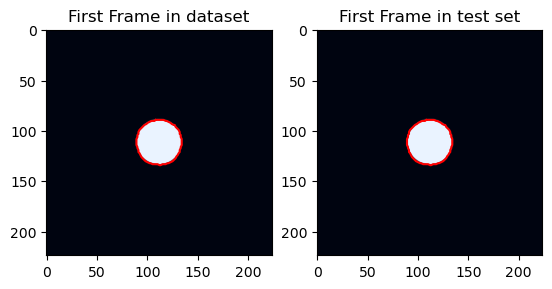

In [7]:
index = 0
plt.subplot(1, 2, 1)
plt.imshow(normalize(fir_img[index]).permute(1, 2, 0))
plt.plot(fir_bou[index][:, 0], fir_bou[index][:, 1], 'r')
plt.title("First Frame in dataset")
plt.subplot(1, 2, 2)
img, bou, sgm = test_set.get_item(video_idx.item(), 0)
plt.imshow(normalize(img).permute(1, 2, 0))
plt.plot(bou[:, 0], bou[:, 1], 'r')
plt.title("First Frame in test set")
plt.show()

Text(0.5, 1.0, 'Current Frame in test set')

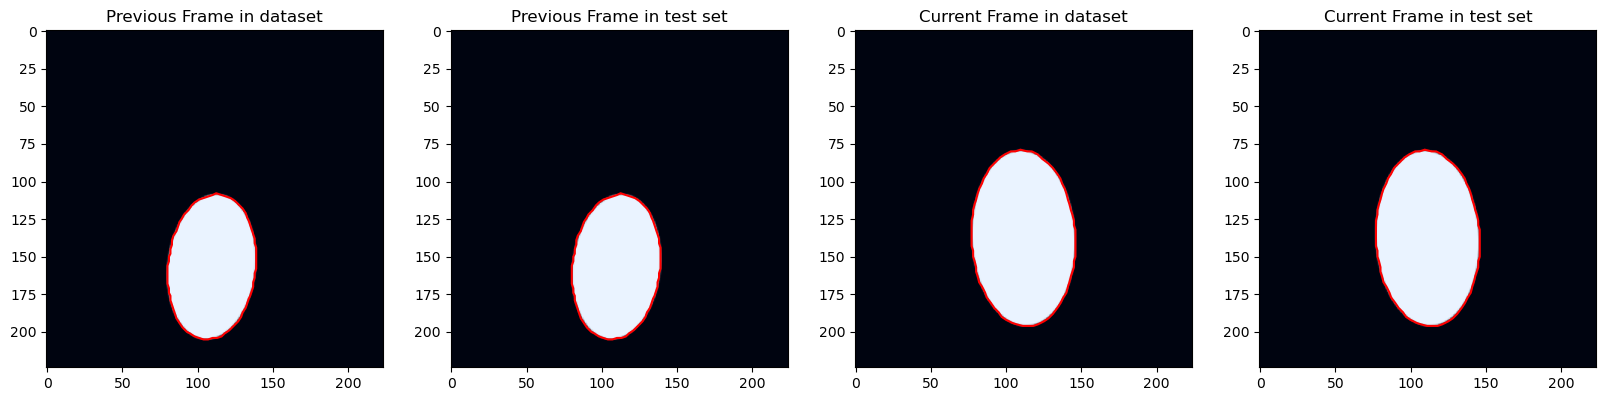

In [8]:
index = 0
plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.imshow(normalize(pre_img[index]).permute(1, 2, 0))
plt.plot(pre_bou[index][:, 0], pre_bou[index][:, 1], 'r')
plt.title("Previous Frame in dataset")
plt.subplot(1, 4, 2)
img, bou, sgm = test_set.get_item(video_idx.item(), pre_idx.item())
plt.imshow(normalize(img).permute(1, 2, 0))
plt.plot(bou[:, 0], bou[:, 1], 'r')
plt.title("Previous Frame in test set")
plt.subplot(1, 4, 3)
plt.imshow(normalize(cur_img[index]).permute(1, 2, 0))
plt.plot(cur_bou[index][:, 0], cur_bou[index][:, 1], 'r')
plt.title("Current Frame in dataset")
plt.subplot(1, 4, 4)
img, bou, sgm = test_set.get_item(video_idx.item(), pre_idx.item() + 1)
plt.imshow(normalize(img).permute(1, 2, 0))
plt.plot(bou[:, 0], bou[:, 1], 'r')
plt.title("Current Frame in test set")

In [9]:
model = FeatupExtra(
    nn.Sequential(
        nn.Conv2d(
            in_channels=384,
            out_channels=384,
            kernel_size=3,
            padding=1,
            stride=1,
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=384,
            out_channels=384,
            kernel_size=3,
            padding=1,
            stride=1,
        ),
        nn.ReLU(),
    )
).cuda()

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main
/work3/s232248/miniconda3/envs/ras/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [10]:
results = model(
    fir_img.cuda(),
    fir_bou.cuda(),
    pre_img.cuda(),
    cur_img.cuda(),
    pre_bou.cuda(),
)

/work3/s232248/miniconda3/envs/ras/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025824022/work/aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [11]:
order_loss(results[-1], cur_bou.cuda())

tensor(25.6261, device='cuda:0', grad_fn=<DivBackward0>)

In [12]:
model_infer = TenVideoInfer(test_set)

In [13]:
model_infer.infer_model(model, 5)

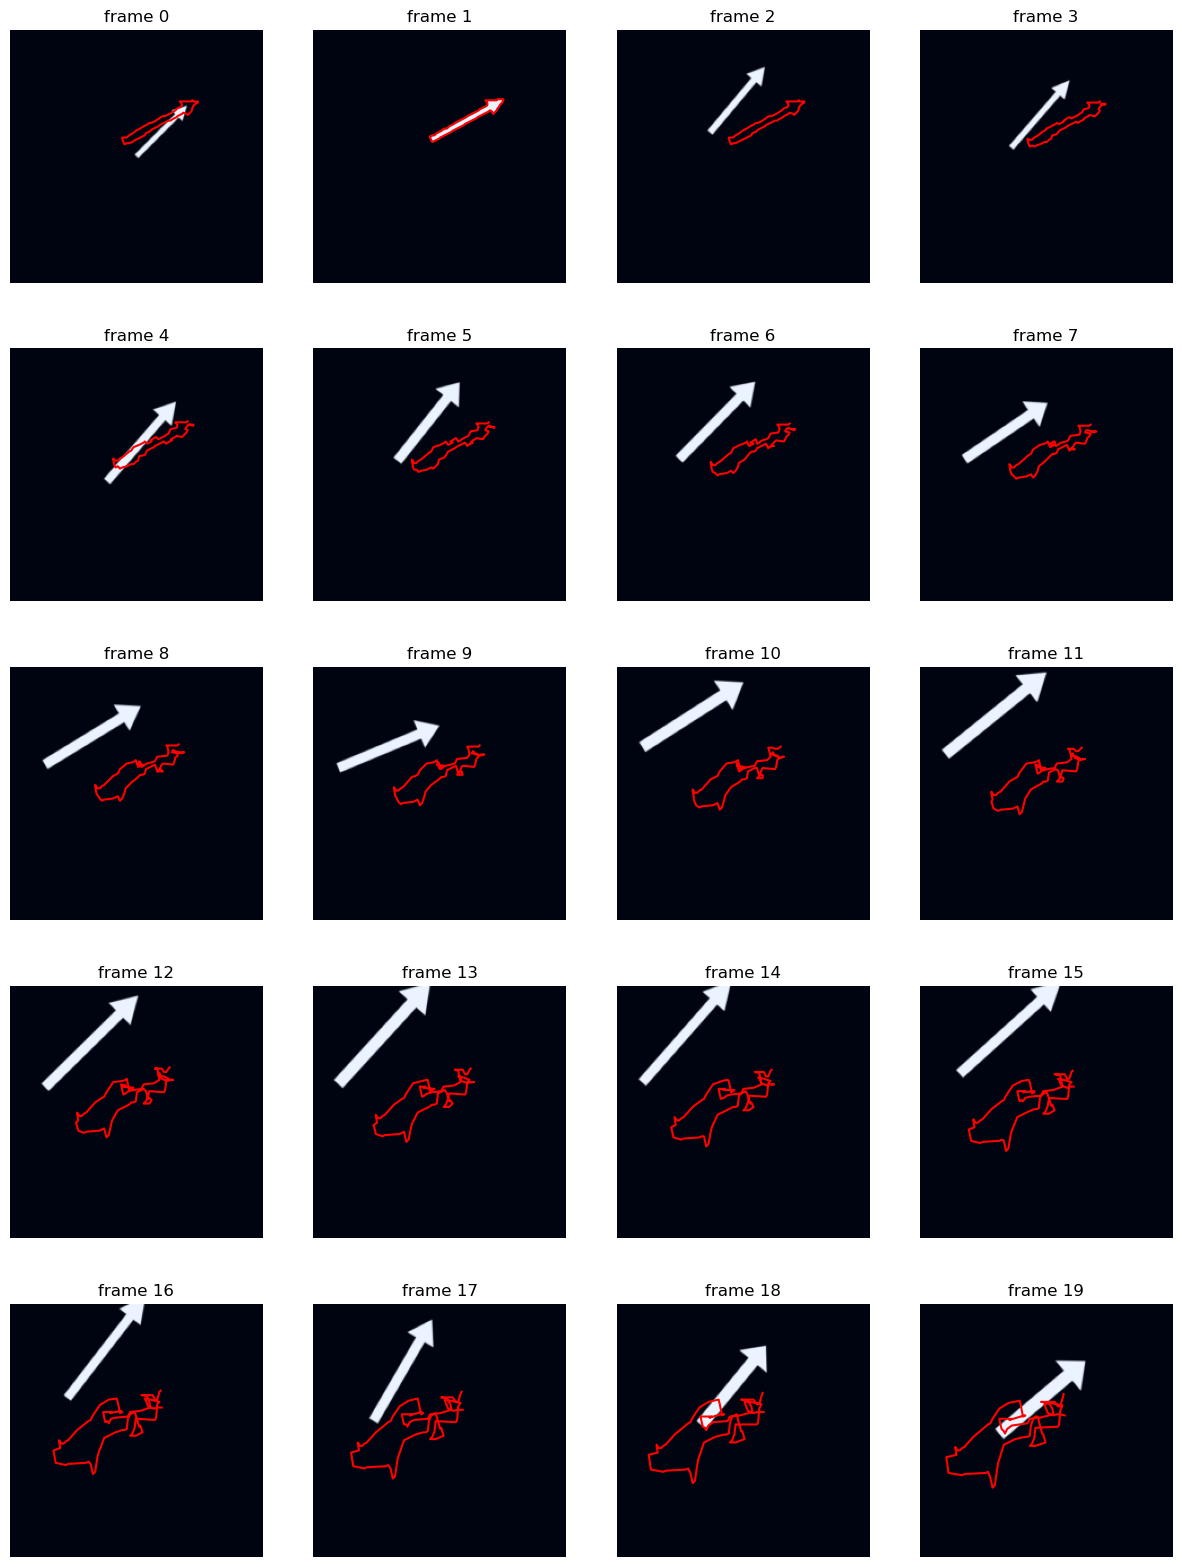

In [18]:
model_infer.show_infer_result(0, 0)

In [29]:
model = FeatupExtra(
    nn.Sequential(
        nn.Conv2d(
            in_channels=384,
            out_channels=384,
            kernel_size=3,
            padding=1,
            stride=1,
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=384,
            out_channels=384,
            kernel_size=3,
            padding=1,
            stride=1,
        ),
        nn.ReLU(),
    )
).cuda()
model_infer = TenVideoInfer(test_set)

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main
/work3/s232248/miniconda3/envs/ras/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [31]:
dict_loss = {}
dict_iou = {}
interval_epochs = 50
inter_num = 47
epoch_index = 0
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)

In [33]:
for interval in range(inter_num):
    for e in range(interval_epochs):
        model.train()
        mean_loss = 0
        for (
            video_idx,
            pre_idx,
            fir_img,
            pre_img,
            cur_img,
            fir_bou,
            pre_bou,
            cur_bou,
        ) in data_loader:
            pre_idx = pre_idx.item()
            video_idx = video_idx.item()
            pre_bou = model_infer.get_boundary(video_idx, pre_idx)
            pre_bou = pre_bou.unsqueeze(0).cuda()
            optimizer.zero_grad()
            results = model(
                fir_img.cuda(),
                fir_bou.cuda(),
                pre_img.cuda(),
                cur_img.cuda(),
                pre_bou.cuda(),
            )
            refine_num = len(results)
            loss = 0
            for i in range(refine_num):
                loss += 0.8 ** (refine_num - i - 1) * order_loss(
                    results[i], cur_bou.cuda()
                )
            loss.backward()
            optimizer.step()
            mean_loss += loss.item()
        mean_loss /= len(data_loader)
        print(f"Epoch {epoch_index}: Loss {mean_loss:.4f}")
        dict_loss[epoch_index] = mean_loss
        epoch_index += 1
    model_infer.infer_model(model)
    total_iou = model_infer.get_total_iou()
    dict_iou[epoch_index] = total_iou
    print(f"Epoch {epoch_index}: Total IOU {total_iou:.4f}")
    if interval_epochs > 20:
        interval_epochs -= 10


Epoch 0: Loss 55.2055


KeyboardInterrupt: 